<a href="https://colab.research.google.com/github/thiagolaitz/IA368-search-engines/blob/main/Project%2002/minilm_ranker_ia368.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install libraries
!pip install transformers -q
!pip install pyserini -q
!pip install faiss-cpu==1.7.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from dataclasses import dataclass

from tqdm.notebook import tqdm

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BatchEncoding,
    get_linear_schedule_with_warmup
)

In [3]:
from collections import defaultdict
from typing import List

import matplotlib.pyplot as plt

from pyserini.search import get_topics
from pyserini.search.lucene import LuceneSearcher


In [4]:
#corpus

!wget https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

--2023-03-16 00:46:57--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  --.-KB/s    in 0.04s   

2023-03-16 00:46:57 (188 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



In [6]:
#10k lines to training
!head -n 10000 "msmarco_triples.train.tiny.tsv" > "msmarco_train.tsv"

#1k lines to validation
!tail -n 1000 "msmarco_triples.train.tiny.tsv" > "msmarco_validation.tsv"

def load_texts(data_path):
    texts = []
    targets = []
    with open(data_path, "r") as data:
      for line in tqdm(data):
        _, pos_doc, neg_doc = line.strip().split("\t")
        texts.append(pos_doc)
        targets.append(1)
        texts.append(neg_doc)
        targets.append(0)
    return texts, targets

x_train, y_train = load_texts("msmarco_train.tsv")
x_test, y_test = load_texts("msmarco_validation.tsv")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
#"microsoft/MiniLM-L12-H384-uncased"
tokenizer_model_name = "nreimers/MiniLM-L6-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)

In [8]:

max_length = 300
x_train_tokenized = tokenizer(x_train, max_length=max_length, truncation=True)
#x_valid_tokenized = tokenizer(x_valid, max_length=max_length, truncation=True)
x_test_tokenized = tokenizer(x_test, max_length=max_length, truncation=True)


## Load Dataset

In [9]:
class Dataset(Dataset):
    def __init__(self, examples, targets):
        self.examples = examples
        self.targets = targets
    
    def __len__(self):
        return len(self.examples['input_ids'])
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.examples['input_ids'][idx],
            'attention_mask': self.examples['attention_mask'][idx],
            'labels': int(self.targets[idx]),
        }

In [10]:
# Convert examples to Pytorch's Dataset.
dataset_train = Dataset(x_train_tokenized, y_train)
#dataset_valid = Dataset(x_valid_tokenized, y_valid)
dataset_test = Dataset(x_test_tokenized, y_test)

In [11]:
# This functions adds "pad" tokens to examples in the batch that are shorter than the largest one.
def collate_fn(batch):
    return BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

# Convert examples to Pytorch's DataLoader.
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Training


In [21]:
# We first define the evaluation function to measure accuracy and loss
from statistics import mean, stdev
def evaluate(model, dataloader, set_name):
    losses = []
    correct = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, mininterval=0.5, desc=set_name, disable=False):
            outputs = model(**batch.to(device))
            loss_val = outputs.loss
            losses.append(loss_val.cpu().item())
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == batch['labels']).sum().item()

    print(f'{set_name} loss: {mean(losses):0.3f}; {set_name} accuracy: {correct / len(dataloader.dataset):0.3f}')
    return mean(losses), (correct / len(dataloader.dataset))


from torch import nn
from torch import optim
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "nreimers/MiniLM-L6-H384-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
print('Parameters', model.num_parameters())

epochs = 5
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(train_dataloader)
# Warm up is important to stabilize training.
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# First validation to check if evaluation code is working and accuracy is random as expected 
evaluate(model=model, dataloader=val_dataloader, set_name='Valid')

# Training loop
train_losses = []
val_losses = []
val_accs = []
    
for epoch in tqdm(range(epochs), desc='Epochs'):
    model.train()
    temp_train_losses = []
    for batch in tqdm(train_dataloader, mininterval=0.5, desc='Train', disable=False):
        optimizer.zero_grad()
        outputs = model(**batch.to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        temp_train_losses.append(loss.cpu().item())

    print(f'Epoch: {epoch + 1} Training loss: {mean(temp_train_losses):0.2f}')
    val_loss, val_acc = evaluate(model=model, dataloader=val_dataloader, set_name='Valid')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    train_losses.append(mean(temp_train_losses))
path_saved_model = "./finetuned_model"
#model.save_model(path_saved_model)
model.save_pretrained(path_saved_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameters 22713986


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 0.694; Valid accuracy: 0.500


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 1 Training loss: 0.62


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 0.688; Valid accuracy: 0.585


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 2 Training loss: 0.33


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 0.943; Valid accuracy: 0.611


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 3 Training loss: 0.15


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 1.291; Valid accuracy: 0.627


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 4 Training loss: 0.08


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 1.406; Valid accuracy: 0.642


Train:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch: 5 Training loss: 0.04


Valid:   0%|          | 0/63 [00:00<?, ?it/s]

Valid loss: 1.575; Valid accuracy: 0.652


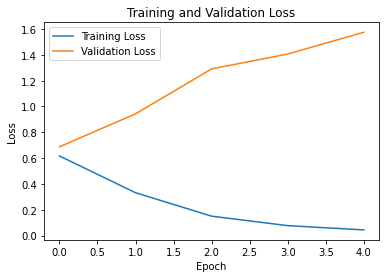

In [23]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss on the same plot
ax.plot(train_losses, label='Training Loss')  
ax.plot(val_losses, label='Validation Loss')

# Set the plot title and labels
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

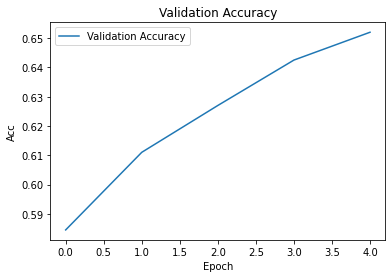

In [24]:
# Plots the accuracy

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss on the same plot
ax.plot(val_accs, label='Validation Accuracy')

# Set the plot title and labels
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Acc')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

# Evaluate on TRECDL-2020



In [ ]:
# Downloads the MsMarco dataset
!wget https://msmarco.blob.core.windows.net/msmarcoranking/collectionandqueries.tar.gz -P collections/msmarco-passage
!tar xvfz collections/msmarco-passage/collectionandqueries.tar.gz -C collections/msmarco-passage

In [31]:
# Get the dictionary containing the IDs of the queries and their texts.
topics = get_topics('dl20')

In [32]:
# Loads the msmarco Dataset
msmarco_dataset = {}
with open("/content/collections/msmarco-passage/collection.tsv", "r") as fin:
    for line in fin:
        docid, content = line.strip().split("\t")
        msmarco_dataset[str(docid)] = content

searcher = LuceneSearcher.from_prebuilt_index('msmarco-passage')

path_bm25_msmarco = "run-msmarco-bm25.tsv"

with open(path_bm25_msmarco, 'w') as runs:
    for id in tqdm(topics, desc="Running queries"):
        query = topics[id]['title']
        top_k = 1000
        hits = searcher.search(query, top_k)
        for idx, hit in enumerate(hits):
          runs.write(f"{id}\tQ0\t{hit.docid}\t{idx+1}\t{hit.score}\tBM25\n")
     

# Loads the bm25 run
bm25_run = defaultdict(list)
with open("/content/"+path_bm25_msmarco, "r") as fin:
    for line in fin:
        qid, _, doc_id, _, _, _ = line.strip().split()
        bm25_run[qid].append((doc_id, msmarco_dataset[str(doc_id)]))

Running queries:   0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
def test_model(model, doc):
  # Add pads to keep all inputs with the same length
  padded_inputs = BatchEncoding(tokenizer.pad(doc, return_tensors="pt")).to(device)
  with torch.no_grad():
      outputs = model(**padded_inputs)

  # Softmax to predict the class (relevant or non-relevant)
  scores = torch.softmax(outputs.logits, dim=1).tolist()
  
  return scores

def get_batch(data, batch_size=32):
  for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(path_saved_model).to(device)
model.eval() # Put the model in evaluation mode        

minilm_scores = defaultdict(list)
for qid, docs in tqdm(bm25_run.items(), desc="Reranking"):
    query = topics[int(qid)]["title"]
    for batch in get_batch(docs):
        doc_batch = [doc[1] for doc in batch]
        doc_batch_tokenized = tokenizer(doc_batch, max_length=max_length, truncation=True)
        scores = test_model(model,doc_batch_tokenized)
        minilm_scores[qid] += list(zip([doc[0] for doc in batch], scores))

Reranking:   0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
# Writes the Minilm Run
with open("minilm_runs.tsv", "w") as runs:
    for qid, scores in minilm_scores.items():
        rank = 0
        #sort the scores based in the relevant probability
        sorted_scores = sorted(scores, key=lambda x: x[1][1], reverse=True)
        for score in sorted_scores:
            rank += 1
            runs.write(f"{qid}\tQ0\t{score[0]}\t{rank}\t{score[1][1]:.3f}\tMinilm\n")

## Results

In [36]:
!python -m pyserini.eval.trec_eval -c -m ndcg_cut.10 -mmap -l 2 dl20-passage minilm_runs.tsv

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar', '-c', '-m', 'ndcg_cut.10', '-mmap', '-l', '2', '/root/.cache/pyserini/topics-and-qrels/qrels.dl20-passage.txt', 'minilm_run.tsv']
Results:
map                   	all	0.0270
ndcg_cut_10           	all	0.0363


# Fix a batch to overfit

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "nreimers/MiniLM-L6-H384-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
print('Parameters', model.num_parameters())

epochs = 200
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = epochs * len(train_dataloader)
# Warm up is important to stabilize training.
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# First validation to check if evaluation code is working and accuracy is random as expected 
evaluate(model=model, dataloader=val_dataloader, set_name='Valid')

# Training loop
for batch in tqdm(train_dataloader, mininterval=0.5, desc='Train', disable=False):
    train_losses = []
    for epoch in tqdm(range(epochs), desc='Epochs'):
      model.train()
      optimizer.zero_grad()
      outputs = model(**batch.to(device))
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      scheduler.step()
      train_losses.append(loss.cpu().item())
      
      print(f'Epoch: {epoch + 1} Training loss: {mean(train_losses):0.2f}')
      evaluate(model=model, dataloader=val_dataloader, set_name='Valid')
    break;

path_saved_model_overfitted = "./overfitted_finetuned_model"
#model.save_model(path_saved_model)
model.save_pretrained(path_saved_model_overfitted)

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(path_saved_model_overfitted).to(device)
model.eval() # Put the model in evaluation mode        

minilm_scores = defaultdict(list)
for qid, docs in tqdm(bm25_run.items(), desc="Reranking"):
    query = topics[int(qid)]["title"]
    for batch in get_batch(docs):
        doc_batch = [doc[1] for doc in batch]
        doc_batch_tokenized = tokenizer(doc_batch, max_length=max_length, truncation=True)
        scores = test_model(model,doc_batch_tokenized)
        minilm_scores[qid] += list(zip([doc[0] for doc in batch], scores))

Reranking:   0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
# Writes the Minilm Run
with open("minilm_runs_overfit.tsv", "w") as runs:
    for qid, scores in minilm_scores.items():
        rank = 0
        #sort the scores based in the relevant probability
        sorted_scores = sorted(scores, key=lambda x: x[1][1], reverse=True)
        for score in sorted_scores:
            rank += 1
            runs.write(f"{qid}\tQ0\t{score[0]}\t{rank}\t{score[1][1]:.3f}\tMinilm\n")

In [42]:
!python -m pyserini.eval.trec_eval -c -m ndcg_cut.10 -mmap -l 2 dl20-passage minilm_runs_overfit.tsv

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar', '-c', '-m', 'ndcg_cut.10', '-mmap', '-l', '2', '/root/.cache/pyserini/topics-and-qrels/qrels.dl20-passage.txt', 'minilm_runs_overfit.tsv']
Results:
map                   	all	0.0186
ndcg_cut_10           	all	0.0120
